In [1]:
from ay_torch import *
%matplotlib widget

In [2]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=torchvision.transforms.ToTensor(),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=torchvision.transforms.ToTensor(),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_train[0] label value: 6 frog
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_test[0] label value: 3 cat


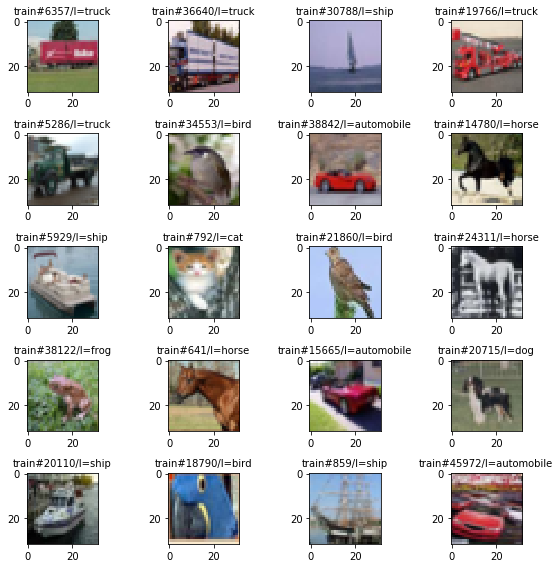

In [4]:
fig= plt.figure(figsize=(8,8))
rows,cols= 5,4
for i in range(rows*cols):
  i_data= np.random.choice(range(len(dset_train)))
  img,label= dset_train[i_data]
  #print(i_data,type(img),img.shape)
  ax= fig.add_subplot(rows, cols, i+1)
  ax.set_title('train#{0}/l={1}'.format(i_data,dset_train.classes[label]), fontsize=10)
  ax.imshow(img.permute(1,2,0))
fig.tight_layout()
plt.show()

In [5]:
class TAlexNet(torch.nn.Module):
  def __init__(self, n_classes):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    self.classifier= torch.nn.Linear(256, n_classes)

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.classifier(x)

In [6]:
#Setup a neural network.
net= net= TAlexNet(n_classes=len(dset_train.classes))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def accuracy(y,y_trg):
  return (y.max(1).indices==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

FindLR progress: 0.0%


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


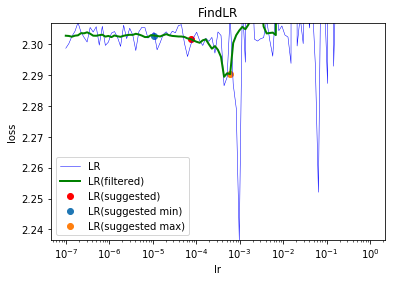

lr= 7.413102413009172e-05, lr_min=1.071519305237606e-05, lr_max=0.000602559586074358


In [7]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
2.06745910	1.82028358	0.31240048	7.054455
1.66144094	1.65268322	0.38813694	6.795736
1.42692616	1.44095747	0.48656449	7.126721
1.29882706	1.26004454	0.54160032	7.189348
1.15420771	1.17239950	0.58489252	6.364204
1.02493851	1.12169623	0.60589172	6.893601
0.89516916	1.12091131	0.60947452	6.336073
0.75593624	1.09198446	0.63256369	6.914610
0.60322820	1.11919972	0.64779061	6.985667
0.43699575	1.23280953	0.65306529	6.905318
0.26891755	1.46090252	0.64878583	6.804200
0.13922093	1.75111271	0.65435908	7.003624
0.06155707	2.05225964	0.65873806	6.922854
0.03111949	2.17864149	0.65983280	6.899760
0.02223702	2.21416739	0.66092755	7.000201


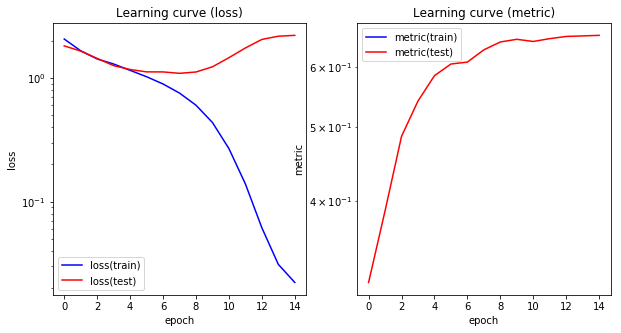

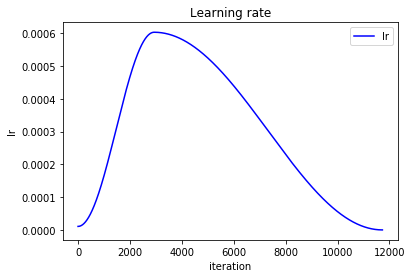

In [8]:
FitOneCycle(net, n_epoch=15, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()